# Comparing means

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

In [2]:
# load the NHANES data library
from nhanes.load import load_NHANES_data
nhanes_data = load_NHANES_data()
adult_nhanes_data = nhanes_data.query('AgeInYearsAtScreening > 17')
## Need to remove duplicates
#nhanes_data=nhanes_data.drop_duplicates(subset ="ID",  keep = 'first', inplace = True)

/Users/johnbutler/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (142) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


We have already encountered a number of cases where we wanted to ask questions about the mean of a sample.  
In this chapter, we will delve deeper into the various ways that we can compare means.


## Testing the value of a single mean

The simplest question we might want to ask of a mean is whether it has a specific value.  Let's say that we want to test whether the mean BMI value in adults from the NHANES dataset is above 25, which is the lower cutoff for being overweight according to the US Centers for Disease Control.  We take a sample of 200 adults in order to ask this question.

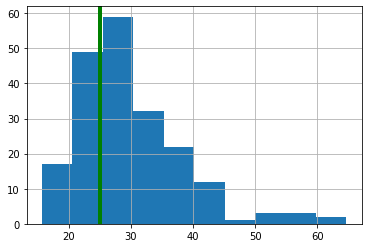

In [3]:
adult_nhanes_data_na=adult_nhanes_data.dropna(subset=['BodyMassIndexKgm2']) # Removing NA's
adult_nhames_sample=adult_nhanes_data_na.sample(n=200, random_state=1)
fig, ax= plt.subplots(1, 1, figsize=(6,4))
ax=adult_nhames_sample['BodyMassIndexKgm2'].hist()
ax.axvline(25,color='g',linewidth=4)

adult_nhames_sample['BMIdiff']=adult_nhames_sample['BodyMassIndexKgm2']>25

One simple way to test for this difference is using a test called the *sign test*, 
which asks whether the proportion of positive differences between the actual value and the hypothesized value is different than what we would expect by chance.  To do this, we take the differences between each data point and the hypothesized mean value and compute their sign.  In our sample, we see that `r I(sprintf('%0.1f',mean(NHANES_sample$BMIdiff)*100))` percent of individuals have a BMI greater than 25.  We can then use a binomial test to ask whether this proportion of positive differences is greater than 0.5, using the `binom_test()` function in Python:

In [4]:
# compute sign test for differences between first and second measurement
npos = np.sum(adult_nhames_sample['BMIdiff'])
bt=stats.binom_test(npos, n=adult_nhames_sample.shape[0], p=0.5, alternative='greater')
print(bt)

2.0076963966165487e-10


Here we see that the proportion of individuals with positive signs would be *very* surprising under the null hypothesis of $p=0.5$. 

We can also ask this question using Student's t-test, which you have already encountered earlier in the book.  We will refer to the mean as $\bar{X}$ and the hypothesized population mean as $\mu$.  Then, the t test for a single mean is:

$$
t = \frac{\bar{X} - \mu}{SEM}
$$
where SEM (as you may remember from the chapter on sampling) is defined as:

$$
SEM = \frac{\hat{\sigma}}{\sqrt{n}}
$$

In essence, the t statistic asks how large the deviation of the sample mean from the hypothesized quantity is with respect to the sampling variability of the mean.

We can compute this for the NHANES dataset using the ```t.ttest_1samp()``` function in Python:

In [5]:
stats.ttest_1samp(adult_nhames_sample['BodyMassIndexKgm2'],5.0)

Ttest_1sampResult(statistic=41.756178548690286, pvalue=2.0768446051226403e-100)

This shows us that the mean BMI in the dataset  is significantly larger than the cutoff for overweight.

## Comparing two means {#comparing-two-means}

A more common question that often arises in statistics is whether there is a difference between the means of two different groups.  Let's say that we would like to know whether regular marijuana smokers watch more television.  We can ask this question using the NHANES dataset; let's take a sample of 200 individuals from the dataset and test whether the number of hours of television watching per day is related to regular marijuana use.  The left panel of Figure \@ref(fig:PotTVViolin) shows these data using a violin plot.

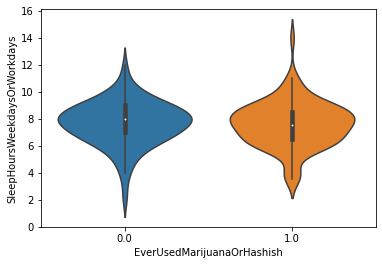

In [35]:
# In the R code it was TVHrsDay

adult_nhanes_data=adult_nhanes_data.dropna(subset=['EverUsedMarijuanaOrHashish','SleepHoursWeekdaysOrWorkdays']) # Removing NA's
adult_nhames_sample=adult_nhanes_data.sample(n=200, random_state=0)
adult_nhames_sample['GenderNum']=adult_nhames_sample['Gender']=='Female'
adult_nhames_sample=adult_nhames_sample[['GenderNum','Gender','SleepHoursWeekdaysOrWorkdays','EverUsedMarijuanaOrHashish']]
ax = sns.violinplot(x=adult_nhames_sample['EverUsedMarijuanaOrHashish'],y=adult_nhames_sample['SleepHoursWeekdaysOrWorkdays'])

In [40]:
Group1 = adult_nhames_sample.loc[adult_nhames_sample['EverUsedMarijuanaOrHashish']==0.0]
Group2 = adult_nhames_sample.loc[adult_nhames_sample['EverUsedMarijuanaOrHashish']==1.0]

We can also use Student's t test to test for differences between two groups of independent observations (as we saw in an earlier chapter); we will turn later in the chapter to cases where the observations are not independent.  As a reminder, the t-statistic for comparison of two independent groups is computed as:

$$
t = \frac{\bar{X_1} - \bar{X_2}}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}
$$

where $\bar{X}_1$ and $\bar{X}_2$ are the means of the two groups, $S^2_1$ and $S^2_2$ are the variances for each of the groups, and $n_1$ and $n_2$ are the sizes of the two groups.  Under the null hypothesis of no difference between means, this statistic is distributed according to a t distribution with n-2 degrees of freedom (since we have computed two parameter estimates, namely the means of the two groups).  We can compute the independent t-test in Python using the ```ttest_ind()``` function. In this case, we started with the specific hypothesis that smoking marijuana is associated with greater TV watching, so we will use a one-tailed test.  Since the t.test function orders the conditions alphabetically, the "No" group comes first, and thus we need to test the alternative hypothesis of whether the first group is less than the second ("Yes") group; for this reason, we specify 'less' as our alternative.

In [41]:
stats.ttest_ind(Group2['SleepHoursWeekdaysOrWorkdays'], Group1['SleepHoursWeekdaysOrWorkdays'])

Ttest_indResult(statistic=-0.2807368001612226, pvalue=0.7792054063820408)

In this case we see that there is a statistically significant difference between groups, in the expected direction - regular pot smokers watch more TV.

## The t-test as a linear model {#ttest-linear-model}

The t-test is often presented as a specialized tool for comparing means, but it can also be viewed as an application of the general linear model.  In this case, the model would look like this:

$$
\hat{TV} = \hat{\beta_1}*Marijuana + \hat{\beta_0}
$$
However, smoking is a binary variable, so we treat it as a *dummy variable* like we discussed in the previous chapter, setting it to a value of 1 for smokers and zero for nonsmokers.  In that case, $\hat{\beta_1}$ is simply the difference in means between the two groups, and $\hat{\beta_0}$ is the mean for the group that was coded as zero.  We can fit this model using the ```ols()``` function, and see that it gives the same t statistic as the t-test above:

In [36]:
from statsmodels.formula.api import ols
ols_model = ols(formula='SleepHoursWeekdaysOrWorkdays~ EverUsedMarijuanaOrHashish + 1', data=adult_nhames_sample)
ols_result = ols_model.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     SleepHoursWeekdaysOrWorkdays   R-squared:                       0.000
Model:                                      OLS   Adj. R-squared:                 -0.005
Method:                           Least Squares   F-statistic:                   0.07881
Date:                          Thu, 23 Jul 2020   Prob (F-statistic):              0.779
Time:                                  21:47:45   Log-Likelihood:                -384.33
No. Observations:                           200   AIC:                             772.7
Df Residuals:                               198   BIC:                             779.3
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.6651      0.159     48.163      0.000       7.351       7.979
EverUsedMarijuanaOrHashish    -0.0662      0.236     -0.281      0.779      -0.532       0.399
==============================================================================
Omnibus:                        9.313   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               17.025
Skew:                          -0.160   Prob(JB):                     0.000201
Kurtosis:                       4.393   Cond. No.                         2.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also view the linear model results graphically (see the right panel of Figure \@ref(fig:PotTVViolin)).  In this case, the predicted value for nonsmokers is $\hat{\beta_0}$ (`r I(lm_summary$coefficients[1,1])`) and the predicted value for smokers is $\hat{\beta_0} +\hat{\beta_1}$ (`r I(lm_summary$coefficients[1,1] + lm_summary$coefficients[2,1])`).  

To compute the standard errors for this analysis, we can use exactly the same equations that we used for linear regression -- since this really is just another example of linear regression.  In fact, if you compare the p-value from the t-test above with the p-value in the linear regression analysis for the marijuana use variable, you will see that the one from the linear regression analysis is exactly twice the one from the t-test, because the linear regression analysis is performing a two-tailed test.  

### Effect sizes for comparing two means

The most commonly used effect size for a comparison between two means is Cohen's d, which (as you may remember from Chapter \@ref(ci-effect-size-power)) is an expression of the effect in terms of standard error units.  For the t-test estimated using the general linear model outlined above (i.e. with a single dummy-coded variable), this is expressed as:

$$
d = \frac{\hat{beta_1}}{SE_{residual}}
$$
We can obtain these values from the analysis output above, giving us a d = `r I(lm_summary$coefficients[2,1]/lm_summary$sigma)`, which we would generally interpret as a medium sized effect.

We can also compute $R^2$ for this analysis, which tells us how much variance in TV watching is accounted for.  This value (which is reported in the summary of the lm() analysis) is `r I(lm_summary$r.squared)`, which tells us that while the effect may be statistically significant, it accounts for relatively little of the variance in TV watching.

## Bayes factor for mean differences

As we discussed in the chapter on Bayesian analysis, Bayes factors provide a way to better quantify evidence in favor or against the null hypothesis of no difference.  In this case, we want to specifically test against the null hypothesis that the difference is greater than zero - because the difference is computed by the function between the first group ('No') and the second group ('Yes'). Thus, we specify a "null interval" going from zero to infinity, which means that the alternative is less than zero.

In [10]:
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()
#import rpy2.robjects.packages as rpackages

In [11]:
# import the BayesFactor package
BayesFactor = importr('BayesFactor')

In [44]:
# import the data frames into the R workspace
robjects.globalenv["Group1"] = Group1
robjects.globalenv["Group2"] = Group2

In [45]:
# perform the standard t-test
ttest_output = r('print(t.test(Group1$SleepHoursWeekdaysOrWorkdays, Group2$SleepHoursWeekdaysOrWorkdays, alternative="greater"))')
# compute the Bayes factor
r('bf = ttestBF(y=Group1$SleepHoursWeekdaysOrWorkdays, x=Group2$SleepHoursWeekdaysOrWorkdays, nullInterval = c(0, Inf))')
r('summary(bf)')


	Welch Two Sample t-test

data:  Group1$SleepHoursWeekdaysOrWorkdays and Group2$SleepHoursWeekdaysOrWorkdays
t = 0.27975, df = 188.82, p-value = 0.39
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -0.3251427        Inf
sample estimates:
mean of x mean of y 
 7.665138  7.598901 

Bayes factor analysis
--------------
[1] Alt., r=0.707 0<d<Inf    : 0.1259773 ±0.07%
[2] Alt., r=0.707 !(0<d<Inf) : 0.1944809 ±0%

Against denominator:
  Null, mu1-mu2 = 0 
---
Bayes factor type: BFindepSample, JZS



<rpy2.rinterface_lib.sexp.NULLType object at 0x7fcd700838c8> [RTYPES.NILSXP]

This shows us that the evidence against the null hypothesis is moderately strong.

## Comparing paired observations

In [14]:
adult_nhanes_data_na=adult_nhanes_data.dropna(subset=['SystolicBloodPres1StRdgMmHg','SystolicBloodPres2NdRdgMmHg']) # Removing NA's
adult_nhames_sample=adult_nhanes_data_na.sample(n=200, random_state=50)
BloodPressure=adult_nhames_sample[['SystolicBloodPres1StRdgMmHg','SystolicBloodPres2NdRdgMmHg']]
BloodPressure.loc[:,'ID']=np.arange(0,200)
BP=BloodPressure.melt(id_vars=['ID'],value_vars = ['SystolicBloodPres1StRdgMmHg','SystolicBloodPres2NdRdgMmHg'],var_name='Order',value_name='Pressure')

/Users/johnbutler/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/johnbutler/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:850: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/Users/johnbutler/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

,ID,Order,Pressure
0,0.0,SystolicBloodPres1StRdgMmHg,142.0
1,1.0,SystolicBloodPres1StRdgMmHg,118.0
2,2.0,SystolicBloodPres1StRdgMmHg,102.0
3,3.0,SystolicBloodPres1StRdgMmHg,110.0
4,4.0,SystolicBloodPres1StRdgMmHg,116.0


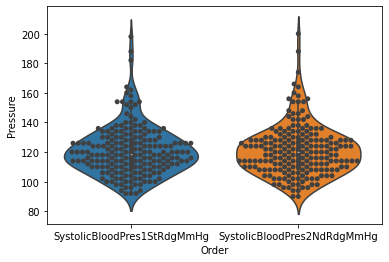

In [15]:
ax = sns.violinplot(x=BP['Order'],y=BP['Pressure'])
ax = sns.swarmplot(x="Order", y="Pressure", data=BP, color=".25")

In [16]:
BloodPressure.loc[:,'BPSdiff']=BloodPressure.loc[:,'SystolicBloodPres1StRdgMmHg']-BloodPressure.loc[:,'SystolicBloodPres2NdRdgMmHg']
#BloodPressure['meanBPS']=(BloodPressure['SystolicBloodPres1StRdgMmHg']+BloodPressure['SystolicBloodPres2NdRdgMmHg'])/2
BloodPressure.loc[:,'meanBPS']=adult_nhanes_data[['SystolicBloodPres1StRdgMmHg', 'SystolicBloodPres2NdRdgMmHg']].mean(1)
BloodPressure.loc[:,'diffPos']=BloodPressure.loc[:,'BPSdiff']>0

/Users/johnbutler/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/johnbutler/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:850: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/Users/johnbutler/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

In experimental research, we often use *within-subjects* designs, in which we compare the same person on multiple measurements.  The measurement that come from this kind of design are often referred to as *repeated measures*. For example, in the NHANES dataset blood pressure was measured three times. Let's say that we are interested in testing whether there is a difference in mean blood pressure between the first and second measurement (Figure  \@ref(fig:BPfig)). We see that there does not seem to be much of a difference in mean blood pressure between time points (about one point). First let's test for a difference using an independent samples t-test, which ignores the fact that pairs of data points come from the the same individuals.   

In [17]:
stats.ttest_ind(BloodPressure['SystolicBloodPres1StRdgMmHg'], BloodPressure['SystolicBloodPres2NdRdgMmHg'])

Ttest_indResult(statistic=-0.047342980126205136, pvalue=0.9622636198648807)

This analysis shows no significant difference. However, this analysis is inappropriate since it assumes that the two samples are independent, when in fact they are not, since the data come from the same individuals.  We can plot the data with a line for each individual to show this (see Figure \@ref(fig:BPLinePlot)).

In this analysis, what we really care about is whether the blood pressure for each person changed in a systematic way between the two measurements, so another way to represent the data is to compute the difference between the two timepoints for each individual, and then analyze these difference scores rather than analyzing the individual measurements. In Figure \@ref(fig:BPDiffHist), we show a histogram of these difference scores, with a blue line denoting the mean difference.

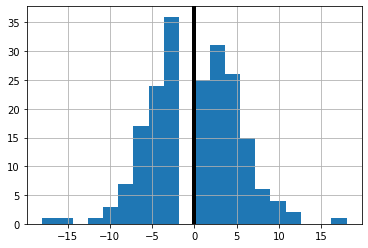

In [18]:
ax=BloodPressure['BPSdiff'].hist(bins=20)
ax.axvline(BloodPressure['BPSdiff'].mean(),color='k',linewidth=4)
plt.show()

### Sign test

One simple way to test for differences is using the *sign test*. To do this, we take the differences and compute their sign, and then we use a binomial test to ask whether the proportion of positive signs differs from 0.5.

In [19]:
npos = np.sum(BloodPressure['diffPos'])
bt=stats.binom_test(npos, n=BloodPressure.shape[0], p=0.5, alternative='greater')
print(bt)

0.9859372963835369


Here we see that the proportion of individuals with positive signs (`r I(bt$estimate)`) is not large enough to be surprising under the null hypothesis of $p=0.5$. However, one problem with the sign test is that it is throwing away information about the magnitude of the differences, and thus might be missing something.

### Paired t-test
A more common strategy is to use a *paired t-test*. We can compute this using the ```ttest_rel()``` function in Python.  

In [20]:
stats.ttest_rel(BloodPressure['SystolicBloodPres1StRdgMmHg'], BloodPressure['SystolicBloodPres2NdRdgMmHg'])

Ttest_relResult(statistic=-0.2237755363963667, pvalue=0.8231615292836318)

This is equivalent to a one-sample t-test ```ttest_1samp()``` for whether the mean difference between the measurements is zero.  

In [21]:
stats.ttest_1samp(BloodPressure['BPSdiff'],popmean=0)

Ttest_1sampResult(statistic=-0.2237755363963667, pvalue=0.8231615292836318)

With this analyses we see that there is in fact a significant difference between the two measurements. Let's compute the Bayes factor to see how much evidence is provided by the result:

In [22]:
robjects.globalenv["BloodPressure"] = BloodPressure
# compute the Bayes factor
r('bf = ttestBF(x=BloodPressure$SystolicBloodPres1StRdgMmHg, y=BloodPressure$SystolicBloodPres2NdRdgMmHg, paired = TRUE, nullInterval = c(0, Inf))')
r('summary(bf)')

Bayes factor analysis
--------------
[1] Alt., r=0.707 0<d<Inf    : 0.06676647 ±0%
[2] Alt., r=0.707 !(0<d<Inf) : 0.09520905 ±0%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS



<rpy2.rinterface_lib.sexp.NULLType object at 0x7fcd700838c8> [RTYPES.NILSXP]

This shows us that although the effect was significant in a paired t-test, it actually provides very little evidence in favor of the alternative hypothesis. 

The paired t-test can also be defined in terms of a linear model; see the Appendix for more details on this.

## Comparing more than two means

Often we want to compare more than two means to determine whether any of them differ from one another.  Let's say that we are analyzing data from a clinical trial for the treatment of high blood pressure.  In the study, volunteers are randomized to one of three conditions: Drug 1, Drug 2 or placebo.  Let's generate some data and plot them (see Figure \@ref(fig:DrugTrial))

In [23]:
nPerGroup= 36

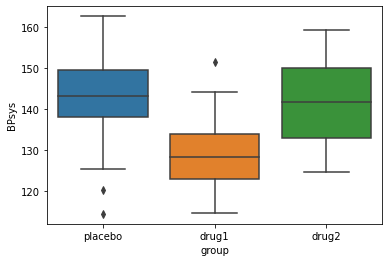

In [24]:
np.random.seed(0)
nPerGroup= 36
noiseSD = 10
meanSysBP = 140
effectSize = 0.8

group=['placebo']*nPerGroup+['drug1']*nPerGroup+['drug2']*nPerGroup
BP1sys=np.random.normal(meanSysBP, noiseSD, nPerGroup)
BP2sys=(np.random.normal(meanSysBP-noiseSD*effectSize, noiseSD, nPerGroup))
BP3sys=(np.random.normal(meanSysBP, noiseSD, nPerGroup))
BPsys=np.concatenate((BP1sys,BP2sys,BP3sys), axis=0)
df=pd.DataFrame({'group': group,'BPsys':BPsys})
ax = sns.boxplot(x="group", y="BPsys", data=df)

### Analysis of variance {#ANOVA}

We would first like to test the null hypothesis that the means of all of the groups are equal -- that is, neither of the treatments had any effect. We can do this using a method called *analysis of variance* (ANOVA). This is one of the most commonly used methods in psychological statistics, and we will only scratch the surface here.  The basic idea behind ANOVA is one that we already discussed in the chapter on the general linear model, and in fact ANOVA is just a name for a specific implementation of such a model.

Remember from the last chapter that we can partition the total variance in the data ($SS_{total}$) into the variance that is explained by the model ($SS_{model}$) and the variance that is not ($SS_{error}$).  We can then compute a *mean square* for each of these by dividing them by their degrees of freedom; for the error this is $N - p$ (where $p$ is the number of means that we have computed), and for the model this is $p - 1$:

$$
MS_{model} =\frac{SS_{model}}{df_{model}}= \frac{SS_{model}}{p-1}
$$

$$
MS_{error} = \frac{SS_{error}}{df_{error}} = \frac{SS_{error}}{N - p}
$$

With ANOVA, we want to test whether the variance accounted for by the model is greater than what we would expect by chance, under the null hypothesis of no differences between means.  Whereas for the t distribution the expected value is zero under the null hypothesis, that's not the case here, since sums of squares are always positive numbers.  Fortunately, there is another standard distribution that describes how ratios of sums of squares are distributed under the null hypothesis: The *F* distribution (see figure \@ref(fig:FDist)). This distribution has two degrees of freedom, which correspond to the degrees of freedom for the numerator (which in this case is the model), and the denominator (which in this case is the error).

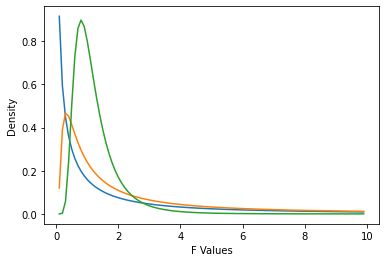

In [25]:
from scipy.stats import f
x=np.arange(0.1,10,0.1)
ax=sns.lineplot(x=x,y=f.pdf(x, 1, 1))
ax=sns.lineplot(x=x,y=f.pdf(x, 50, 1))
ax=sns.lineplot(x=x,y=f.pdf(x, 50, 10))
ax.set(xlabel='F Values', ylabel='Density')
plt.show()

To create an ANOVA model, we extend the idea of *dummy coding* that you encountered in the last chapter. Remember that for the t-test comparing two means, we created a single dummy variable that took the value of 1 for one of the conditions and zero for the others.  Here we extend that idea by creating two dummy variables, one that codes for the Drug 1 condition and the other that codes for the Drug 2 condition.  Just as in the t-test, we will have one condition (in this case, placebo) that doesn't have a dummy variable, and thus represents the baseline against which the others are compared; its mean defines the intercept of the model. Let's create the dummy coding for drugs 1 and 2.

In [26]:
df['drug1']=df['group']=='drug1'
df['drug2']=df['group']=='drug2'

Now we can fit a model using the same approach that we used in the previous chapter:

In [27]:

ols_model = ols(formula='BPsys~ drug1+drug2', data=df)
ols_result = ols_model.fit()
aov_table = sm.stats.anova_lm(ols_result)
aov_table 

,df,sum_sq,mean_sq,F,PR(>F)
drug1,1.0,4336.449081,4336.449081,42.148824,2.866901e-09
drug2,1.0,29.053463,29.053463,0.282390,5.962615e-01
Residual,105.0,10802.843544,102.884224,NaN,NaN


The output from this command provides us with two things.  First, it shows us the result of a t-test for each of the dummy variables, which basically tell us whether each of the conditions separately differs from placebo; it appears that Drug 1 does whereas Drug 2 does not.  However, keep in mind that if we wanted to interpret these tests, we would need to correct the p-values to account for the fact that we have done multiple hypothesis tests; we will see an example of how to do this in the next chapter.

Remember that the hypothesis that we started out wanting to test was whether there was any difference between any of the conditions; we refer to this as an *omnibus* hypothesis test, and it is the test that is provided by the F statistic. The F statistic basically tells us whether our model is better than a simple model that just includes an intercept.  In this case we see that the F test is highly significant, consistent with our impression that there did seem to be differences between the groups (which in fact we know there were, because we created the data).

In [29]:
ols_model = ols(formula='BPsys~ group', data=df)
ols_result = ols_model.fit()
aov_table = sm.stats.anova_lm(ols_result)
aov_table 

,df,sum_sq,mean_sq,F,PR(>F)
group,2.0,4365.502544,2182.751272,21.215607,1.825965e-08
Residual,105.0,10802.843544,102.884224,NaN,NaN


In [30]:
import pingouin as pg
pg.anova(data=df, dv='BPsys',between='group', effsize="np2")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,105,21.215607,1.825965e-08,0.287803


In [31]:
pg.pairwise_tukey(data=df, dv='BPsys', between='group')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,drug1,drug2,128.911357,141.718051,-12.806694,2.390772,two-sided,-5.356719,0.001000,-1.249015
1,drug1,placebo,128.911357,142.988516,-14.077159,2.390772,two-sided,-5.888123,0.001000,-1.372921
2,drug2,placebo,141.718051,142.988516,-1.270465,2.390772,two-sided,-0.531404,0.839669,-0.123906


## Learning objectives

After reading this chapter, you should be able to:

* Describe the rationale behind the sign test
* Describe how the t-test can be used to compare a single mean to a hypothesized value
* Compare the means for two paired or unpaired groups using a two-sample t-test


## Appendix

### The paired t-test as a linear model

We can also define the paired t-test in terms of a general linear model.  To do this, we include all of the measurements for each subject as data points (within a tidy data frame).  We then include in the model a variable that codes for the identity of each individual (in this case, the ID variable that contains a subject ID for each person). This is known as a *mixed model*, since it includes effects of independent variables as well as effects of individuals.  The standard model fitting procedure ```lm()``` can't do this, but we can do it using the ```lmer()``` function from a popular R package called *lme4*, which is specialized for estimating mixed models.  The ```(1|ID)``` in the formula tells `lmer()` to estimate a separate intercept (which is what the ```1``` refers to) for each value of the ```ID``` variable (i.e. for each individual in the dataset), and then estimate a common slope relating timepoint to BP.

In [34]:
ols_model = ols(formula='BPsys~ drug1+drug2 + 1', data=df)
ols_result = ols_model.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  BPsys   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     21.22
Date:                Thu, 23 Jul 2020   Prob (F-statistic):           1.83e-08
Time:                        21:40:33   Log-Likelihood:                -401.94
No. Observations:                 108   AIC:                             809.9
Df Residuals:                     105   BIC:                             817.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       142.9885      1.691     84.582      0.000     139.637     146.341
drug1[T.True]   -14.0772      2.391     -5.888      0.000     -18.818      -9.337
drug2[T.True]    -1.2705      2.391     -0.531      0.596      -6.011       3.470
==============================================================================
Omnibus:                        0.257   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.879   Jarque-Bera (JB):                0.431
Skew:                          -0.056   Prob(JB):                        0.806
Kurtosis:                       2.712   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You can see that this shows us a p-value that is very close to the result from the paired t-test computed using the ```t.test()``` function.